In [4]:
# load_dtypes()
# DF 불러올 때부터 축소해서 가져오는 함수.

def load_dtypes(file_path):
    print(file_path)
    tmp = pd.read_csv(file_path, nrows=0) # 애초에 파일을 불러올 때
    col_dtypes= {}
    for col in tmp.columns:
        df = pd.read_csv(file_path, usecols=[col]) # 애초에 파일을 불러올 때
        
        dtype = df[col].dtype
        
        if (dtype == 'int8' or dtype == 'int16' or dtype == 'int32' or dtype == 'int64'):
            c_min = df[col].min()
            c_max = df[col].max()
            dtype = 'int'
            
        elif dtype == 'float32' or dtype == 'float64':
            c_min = df[col].min()
            c_max = df[col].max()
            dtype = 'float'
            
        elif dtype == 'object':
            n_unique = df[col].nunique()
            threshold = n_unique / df.shape[0]
            
        if dtype == 'int':
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                col_dtype = 'int8'
            elif c_min > np.iinfo(np.uint8).min and c_max < np.iinfo(np.uint8).max:
                col_dtype = 'uint8'
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                col_dtype = 'int16'
            elif c_min > np.iinfo(np.uint16).min and c_max < np.iinfo(np.uint16).max:
                col_dtype = 'uint16'
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                col_dtype = 'int32'
            elif c_min > np.iinfo(np.uint32).min and c_max < np.iinfo(np.uint32).max:
                col_dtype = 'uint32'
            elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                col_dtype = 'int64'
            elif c_min > np.iinfo(np.uint64).min and c_max < np.iinfo(np.uint64).max:
                col_dtype = 'uint64'
                
        elif dtype == 'float':
            if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                col_dtype = 'float32'
            else:
                col_dtype = 'float64'
                
        elif dtype == 'object':
            if threshold > 0.7:
                col_dtype = 'object'
            else:
                col_dtype = 'category'
                
        col_dtypes[col] = col_dtype
        

    df = pd.read_csv(file_path, dtype=col_dtypes)
    
    return df

# AVG, VAR 파생변수 생성 모델입니다.

변수 중요도가 높은 습도와 기온으로 무언가를 할 수 있지 않을까 하여 생각해 낸 것입니다.<br>
원래는 계절을 넣어주고 싶었지만, 그건 너무 어렵고, 일 평균 기온이나 습도를 넣어주면 얼추 영향을 미치지 않을까 한 것입니다.

중요한 건 지금 shiftedModel 이 문제가 있으니, 일단 baseModel로 진행을 할 것입니다.

In [5]:
import pandas as pd
import numpy as np
import os, sys
import glob
import random
import math
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
TRAIN_PATH = r'C:\Users\Wyatt\wyatt37\Data\solarpanel\train\train.csv'
TEST_PATH = r'C:\Users\Wyatt\wyatt37\Data\solarpanel\test'
SUBMISSION_PATH = r'C:\Users\Wyatt\wyatt37\Data\solarpanel\sample_submission.csv'

In [7]:
train = load_dtypes(TRAIN_PATH)
train.info()

C:\Users\Wyatt\wyatt37\Data\solarpanel\train\train.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52560 entries, 0 to 52559
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Day     52560 non-null  int16  
 1   Hour    52560 non-null  int8   
 2   Minute  52560 non-null  int8   
 3   DHI     52560 non-null  int16  
 4   DNI     52560 non-null  int16  
 5   WS      52560 non-null  float32
 6   RH      52560 non-null  float32
 7   T       52560 non-null  int8   
 8   TARGET  52560 non-null  float32
dtypes: float32(3), int16(3), int8(3)
memory usage: 1.1 MB


In [8]:
submission = pd.read_csv(SUBMISSION_PATH)

In [9]:
def sum_hour_minute(train):
    # 0과 30으로 되어 있는 minute을 0과 0.5로 바꿉니다.
    train.Minute = round(train.Minute * 0.017, 1)
    # hour에 minute을 더해줍니다.
    train.Hour = train.Hour + train.Minute
    
    return train

# DHI의 값에 따라서 0~180의 값을 가지는 정규화 함수입니다.

def angle_normalizor(list_, lags=48):
    min_ = min(list_)
    max_ = max(list_)
    return ((list_ - min_) / (max_ - min_))*180

# 천정각에 의해 GHI를 출력하는 함수입니다.

def ghi_formula(DHI, DNI, theta):
    return (DHI + (DNI*np.cos((np.abs(theta-90)-1)*0.0174533)))

# 하루 단위로(48개 index) DHI에 따른 천정각으로 GHI를 만들어주는 함수입니다.

def make_GHI(train, start_window=0, window=48):
    
    end_window = train.shape[0] / window
    #stride = window
    DHI = train.DHI # DHI value 값을 받습니다.
    DNI = train.DNI # DNI value 값을 받습니다.
    GHI = []
    
    #for i in tqdm(range(3)): # 테스트용 코드
    for i in range(np.int(end_window)):
        #print(i)
        if i == 0:
            #print(start_window)
            dhi_window = DHI[start_window:window] # 0부터 window=48 까지를 슬라이싱 해서 받습니다.
            dni_window = DNI[start_window:window]
            # 정규화 시키고,
            dhi_normal = angle_normalizor(dhi_window)
            # GHI 만들고
            new_GHI = ghi_formula(dhi_window, dni_window, dhi_normal)
            # 리스트에 더해줍니다.
            GHI = GHI + list(new_GHI)
        else:
            #print(window)
            dhi_window = DHI[(window*i):(window*(i+1))] # window*i 부터 window*(i+1) 까지를 슬라이싱
            dni_window = DNI[(window*i):(window*(i+1))]
            # 정규화 시키고,
            dhi_normal = angle_normalizor(dhi_window)
            # GHI 만들고
            new_GHI = ghi_formula(dhi_window, dni_window, dhi_normal)
            # 리스트에 더해줍니다.
            GHI = GHI + list(new_GHI)

            #window += stride # 윈도우를 옆으로 stride 시켜준다.
            
            
    train['GHI'] = GHI
    return train

# 시간에 따른 천정각 추가 함수
def time_sun_angle(train):
    
    one_radial = 6.17
    renew_radial = 0
    angle = []

    for i in range(48):
        if (i/2) > 19.1:
            angle.append(1)

        elif (i/2) > 4.9:
            renew_radial += one_radial
            angle.append(renew_radial)
        else:
            angle.append(1)

        i += 0.5
        
    train['ANGLE'] = angle*(int(train.shape[0]/48))
    
    return train

# sun_angle 에 따른 GHI 만드는 함수
def sun_angle_ghi(train):
    train['NEW_GHI'] = train['DHI'] + (train['DNI']*(np.cos((train['ANGLE'] - 90)*0.0174533)))
    
    return train

# 총 일사량 만들기
def total_irradiance(train):
    train['TA'] = train.DHI + train.DNI
    
    return train

# 파생변수 만드는 함수
def make_features(train):
    print("original_shape: ", train.shape)
    # hour와 minute 합쳐줍니다.
    train = sum_hour_minute(train)
    
    #-------------------- 파생변수 생성하면 이 아래에 추가
    new_train = make_GHI(train, start_window=0, window=48)
    # 일단 sun_angle을 만듭니다.
    new_train = time_sun_angle(new_train)
    # new_ghi 만듭니다.
    new_train = sun_angle_ghi(new_train)
    # total irradiance 만듭니다.
    new_train = total_irradiance(new_train)
    
    # 필요 없는 column 을 지워줍니다.
    new_train.drop(['Day', 'Minute', 'ANGLE'], axis=1, inplace=True)  
    
    print("feature_creationed: ", new_train.shape)
    
    return new_train

In [10]:
train = make_features(train)
train

original_shape:  (52560, 9)
feature_creationed:  (52560, 10)


,Hour,DHI,DNI,WS,RH,T,TARGET,GHI,NEW_GHI,TA
0,0.0,0,0,1.5,69.080002,-12,0.0,0.0,0.0,0
1,0.5,0,0,1.5,69.059998,-12,0.0,0.0,0.0,0
2,1.0,0,0,1.6,71.779999,-12,0.0,0.0,0.0,0
3,1.5,0,0,1.6,71.750000,-12,0.0,0.0,0.0,0
4,2.0,0,0,1.6,75.199997,-12,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...
52555,21.5,0,0,2.4,70.699997,-4,0.0,0.0,0.0,0
52556,22.0,0,0,2.4,66.790001,-4,0.0,0.0,0.0,0
52557,22.5,0,0,2.2,66.779999,-4,0.0,0.0,0.0,0
52558,23.0,0,0,2.1,67.720001,-4,0.0,0.0,0.0,0


In [11]:
# 하루 단위로 평균 기온, 분산 기온, 평균 습도, 분산 습도, 평균 풍속, 

def make_AVGVAR(train, start_window=0, window=48):
    
    end_window = train.shape[0] / window
    #stride = window
    RH = train['RH'] # DHI value 값을 받습니다.
    TP = train['T'] # DNI value 값을 받습니다.
    
    RH_AVG = []
    TP_AVG = []
    RH_VAR = []
    TP_VAR = []
    
    #for i in tqdm(range(3)): # 테스트용 코드
    for i in range(np.int(end_window)):
        #print(i)
        if i == 0:
            #print(start_window)
            rh_window = RH[start_window:window] # 0부터 window=48 까지를 슬라이싱 해서 받습니다.
            tp_window = TP[start_window:window]
            # 평균을 뽑아줍니다.
            rh_avg = rh_window.mean()
            tp_avg = tp_window.mean()
            # 분산을 뽑아줍니다.
            rh_var = rh_window.var()
            tp_var = tp_window.var()
            # 리스트로 만들어줍니다.
            rh_avg_list = [rh_avg]*48
            tp_avg_list = [tp_avg]*48
            rh_var_list = [rh_var]*48
            tp_var_list = [tp_var]*48
            
            # 리스트에 더해줍니다.
            RH_AVG = RH_AVG + rh_avg_list
            TP_AVG = TP_AVG + tp_avg_list
            RH_VAR = RH_VAR + rh_var_list
            TP_VAR = TP_VAR + tp_var_list
        else:
            #print(window)
            rh_window = RH[(window*i):(window*(i+1))] # window*i 부터 window*(i+1) 까지를 슬라이싱
            tp_window = TP[(window*i):(window*(i+1))]
            # 평균을 뽑아줍니다.
            rh_avg = rh_window.mean()
            tp_avg = tp_window.mean()
            # 분산을 뽑아줍니다.
            rh_var = rh_window.var()
            tp_var = tp_window.var()
            # 리스트로 만들어줍니다.
            rh_avg_list = [rh_avg]*48
            tp_avg_list = [tp_avg]*48
            rh_var_list = [rh_var]*48
            tp_var_list = [tp_var]*48
            
            # 리스트에 더해줍니다.
            RH_AVG = RH_AVG + rh_avg_list
            TP_AVG = TP_AVG + tp_avg_list
            RH_VAR = RH_VAR + rh_var_list
            TP_VAR = TP_VAR + tp_var_list
            
    train['RH_AVG'] = RH_AVG
    train['TP_AVG'] = TP_AVG
    train['RH_VAR'] = RH_VAR
    train['TP_VAR'] = TP_VAR
    
    return train

In [12]:
train = make_AVGVAR(train)

In [13]:
train

,Hour,DHI,DNI,WS,RH,T,TARGET,GHI,NEW_GHI,TA,RH_AVG,TP_AVG,RH_VAR,TP_VAR
0,0.0,0,0,1.5,69.080002,-12,0.0,0.0,0.0,0,70.329384,-7.979167,80.515747,10.020833
1,0.5,0,0,1.5,69.059998,-12,0.0,0.0,0.0,0,70.329384,-7.979167,80.515747,10.020833
2,1.0,0,0,1.6,71.779999,-12,0.0,0.0,0.0,0,70.329384,-7.979167,80.515747,10.020833
3,1.5,0,0,1.6,71.750000,-12,0.0,0.0,0.0,0,70.329384,-7.979167,80.515747,10.020833
4,2.0,0,0,1.6,75.199997,-12,0.0,0.0,0.0,0,70.329384,-7.979167,80.515747,10.020833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52555,21.5,0,0,2.4,70.699997,-4,0.0,0.0,0.0,0,62.066051,-2.708333,160.094528,3.359929
52556,22.0,0,0,2.4,66.790001,-4,0.0,0.0,0.0,0,62.066051,-2.708333,160.094528,3.359929
52557,22.5,0,0,2.2,66.779999,-4,0.0,0.0,0.0,0,62.066051,-2.708333,160.094528,3.359929
52558,23.0,0,0,2.1,67.720001,-4,0.0,0.0,0.0,0,62.066051,-2.708333,160.094528,3.359929


In [15]:
# 타겟값을 미리 만들어줘야 합니다.
train['TARGET_1'] = train.TARGET.shift(48)
train['TARGET_2'] = train.TARGET_1.shift(48)

In [17]:
train.dropna(inplace=True)

In [19]:
train

,Hour,DHI,DNI,WS,RH,T,TARGET,GHI,NEW_GHI,TA,RH_AVG,TP_AVG,RH_VAR,TP_VAR,TARGET_1,TARGET_2
96,0.0,0,0,2.2,73.800003,-8,0.0,0.0,0.0,0,76.275002,-6.479167,47.676655,17.574025,0.0,0.0
97,0.5,0,0,2.1,68.199997,-8,0.0,0.0,0.0,0,76.275002,-6.479167,47.676655,17.574025,0.0,0.0
98,1.0,0,0,2.1,69.059998,-8,0.0,0.0,0.0,0,76.275002,-6.479167,47.676655,17.574025,0.0,0.0
99,1.5,0,0,2.1,69.040001,-8,0.0,0.0,0.0,0,76.275002,-6.479167,47.676655,17.574025,0.0,0.0
100,2.0,0,0,2.2,69.379997,-8,0.0,0.0,0.0,0,76.275002,-6.479167,47.676655,17.574025,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52555,21.5,0,0,2.4,70.699997,-4,0.0,0.0,0.0,0,62.066051,-2.708333,160.094528,3.359929,0.0,0.0
52556,22.0,0,0,2.4,66.790001,-4,0.0,0.0,0.0,0,62.066051,-2.708333,160.094528,3.359929,0.0,0.0
52557,22.5,0,0,2.2,66.779999,-4,0.0,0.0,0.0,0,62.066051,-2.708333,160.094528,3.359929,0.0,0.0
52558,23.0,0,0,2.1,67.720001,-4,0.0,0.0,0.0,0,62.066051,-2.708333,160.094528,3.359929,0.0,0.0


In [20]:
X = train[:40000]
val = train[40000:]

In [18]:
def make_train_test_val(X, val, features):

    x_train = X[features]
    y_train_1 = X['TARGET_1']
    y_train_2 = X['TARGET_2']

    x_val = val[features]
    y_val_1 = val['TARGET_1']
    y_val_2 = val['TARGET_2']
    
    print(x_train.shape)
    
    return x_train, y_train_1, y_train_2, x_val, y_val_1, y_val_2

In [22]:
x_train, y_train_1, y_train_2, x_val, y_val_1, y_val_2 = make_train_test_val(X, val, X.columns[:-2])

(40000, 14)


In [24]:
class HiddenPrints: # print를 막아주는 클래스 입니다.
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout
        
with HiddenPrints():
    df_test = []

    for i in range(81):
        file_path = TEST_PATH + '/' + str(i) + '.csv'
        temp = pd.read_csv(file_path)

        temp = make_features(temp)
        temp = make_AVGVAR(temp)
        temp = temp[-48:]
        df_test.append(temp)

    X_test = pd.concat(df_test)
print(X_test.shape)

(3888, 14)


In [25]:
X_test

,Hour,DHI,DNI,WS,RH,T,TARGET,GHI,NEW_GHI,TA,RH_AVG,TP_AVG,RH_VAR,TP_VAR
288,0.0,0,0,0.8,80.92,-2.8,0.0,0.0,0.0,0,65.420833,-5.487500,80.669008,2.742819
289,0.5,0,0,0.9,81.53,-2.9,0.0,0.0,0.0,0,65.420833,-5.487500,80.669008,2.742819
290,1.0,0,0,1.0,79.91,-3.0,0.0,0.0,0.0,0,65.420833,-5.487500,80.669008,2.742819
291,1.5,0,0,0.9,79.91,-3.0,0.0,0.0,0.0,0,65.420833,-5.487500,80.669008,2.742819
292,2.0,0,0,0.9,77.20,-3.0,0.0,0.0,0.0,0,65.420833,-5.487500,80.669008,2.742819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,21.5,0,0,0.8,63.35,13.7,0.0,0.0,0.0,0,45.947500,18.154167,413.462555,33.618280
332,22.0,0,0,0.7,64.82,13.1,0.0,0.0,0.0,0,45.947500,18.154167,413.462555,33.618280
333,22.5,0,0,0.7,66.10,12.8,0.0,0.0,0.0,0,45.947500,18.154167,413.462555,33.618280
334,23.0,0,0,0.6,67.64,12.4,0.0,0.0,0.0,0,45.947500,18.154167,413.462555,33.618280


In [26]:
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [27]:
# Get the model and the predictions in (a) - (b)
def LGBM(q, X_train, Y_train, X_valid, Y_valid, X_test):
    
    # (a) Modeling  
    model = LGBMRegressor(objective='quantile', # quantile로 받아줘야 quatile regression이 가능합니다.
                          alpha=q, # 이건 나중에 quantile 받을 인자입니다.
                          n_estimators=10000, # 10000만번을 돌리겠다고? 미쳤어?
                          bagging_fraction=0.7,
                          learning_rate=0.027,
                          subsample=0.7)                   
                         
                         
    model.fit(X_train,
              Y_train,
              eval_metric = ['quantile'],
              eval_set=[(X_valid, Y_valid)],
              early_stopping_rounds=300, verbose=500) # 대신 얼리 스토핑을 넣었네요.

    # (b) Predictions
    pred = pd.Series(model.predict(X_test).round(2))
    return pred, model

In [28]:
# Target 예측

def train_data(X_train, Y_train, X_valid, Y_valid, X_test):

    LGBM_models=[]
    LGBM_actual_pred = pd.DataFrame()

    for q in quantiles: # 9번 반복할 겁니다. quantile 마다.
        print(q)
        pred , model = LGBM(q, # 퀀틸 박아줍니다.
                            X_train, Y_train, X_valid, Y_valid, X_test)
        LGBM_models.append(model) # 모델을 어펜드 해줍니다.
        LGBM_actual_pred = pd.concat([LGBM_actual_pred,pred],axis=1) #pred를 컨캣해줍니다.

    LGBM_actual_pred.columns=quantiles # 컬럼은 퀀틸로 박아줍니다.
    
    return LGBM_models, LGBM_actual_pred

In [29]:
# Target1
models_1, results_1 = train_data(x_train, y_train_1, x_val, y_val_1, X_test)

# Target2
models_2, results_2 = train_data(x_train, y_train_2, x_val, y_val_2, X_test)

0.1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[128]	valid_0's quantile: 1.48006
0.2
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[161]	valid_0's quantile: 2.36146
0.3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[183]	valid_0's quantile: 2.80649
0.4
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.98367
Early stopping, best iterat

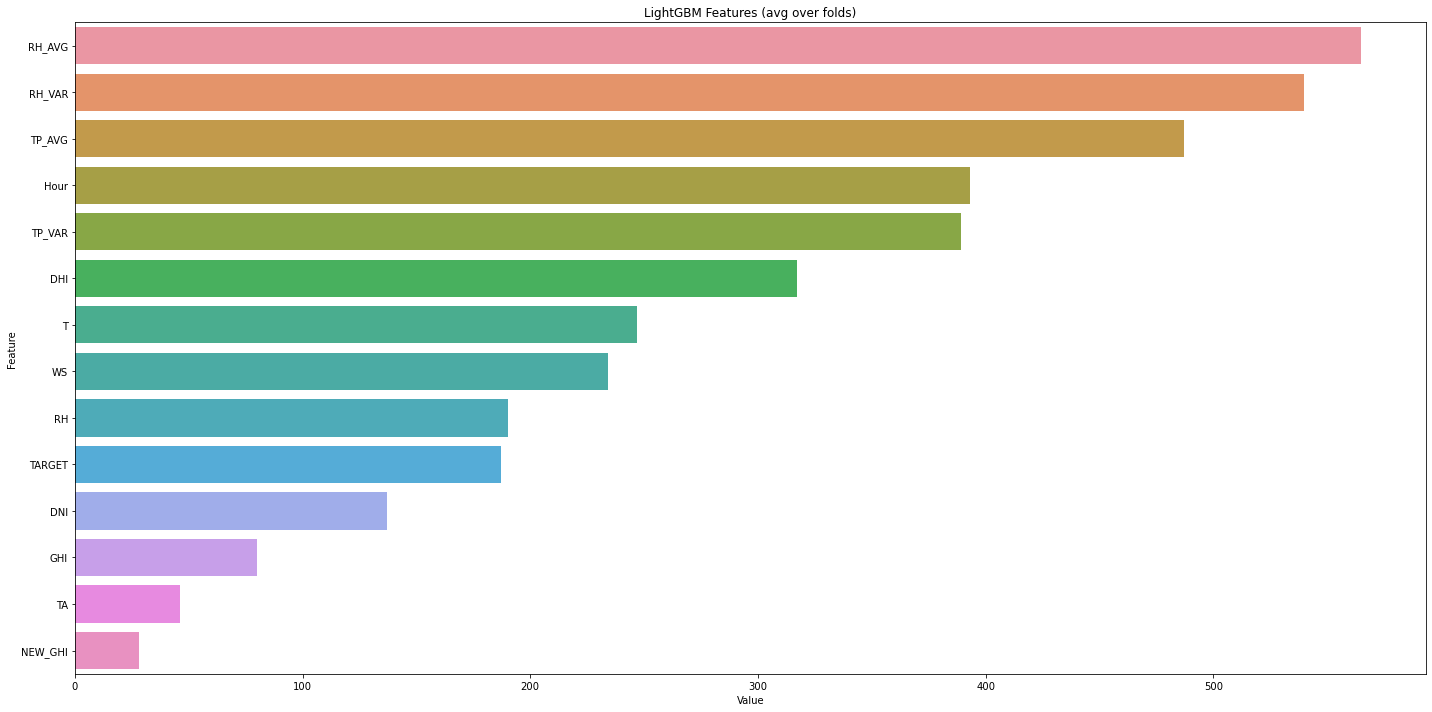

<Figure size 432x288 with 0 Axes>

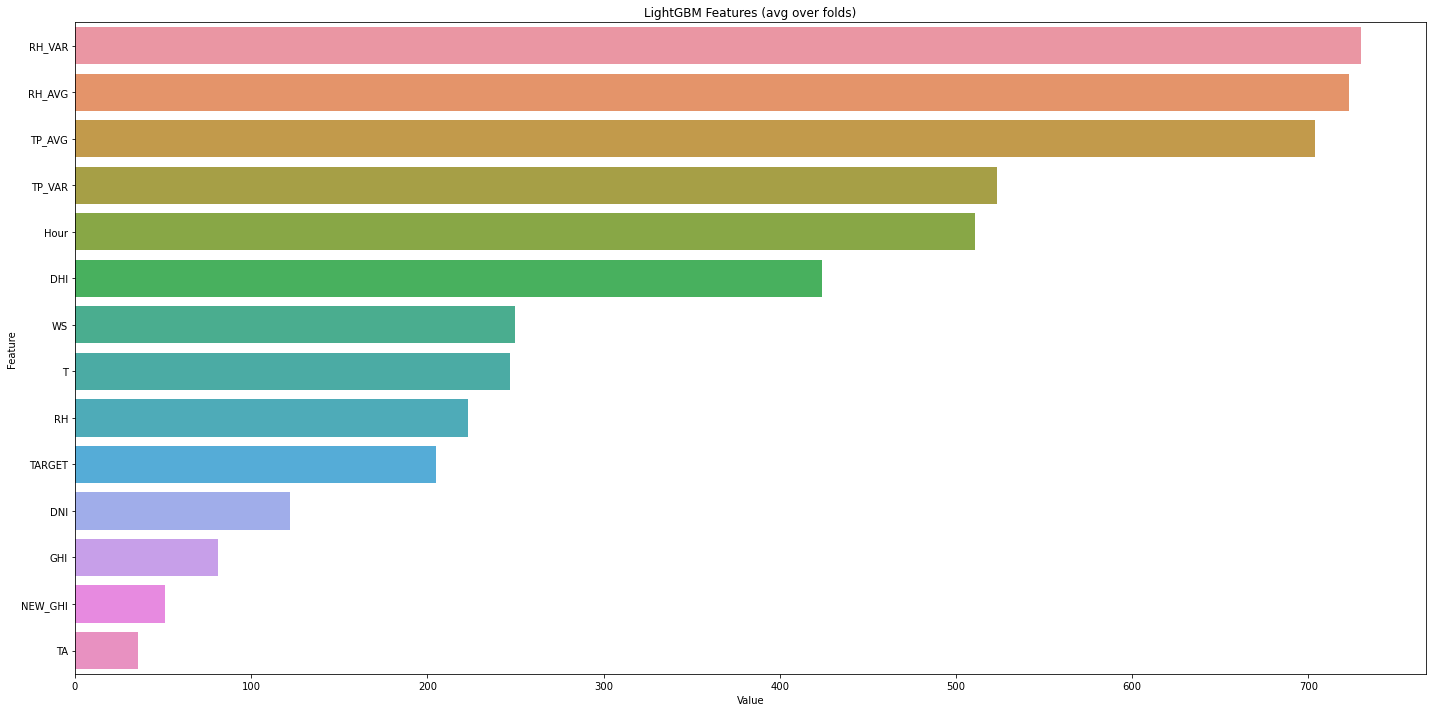

<Figure size 432x288 with 0 Axes>

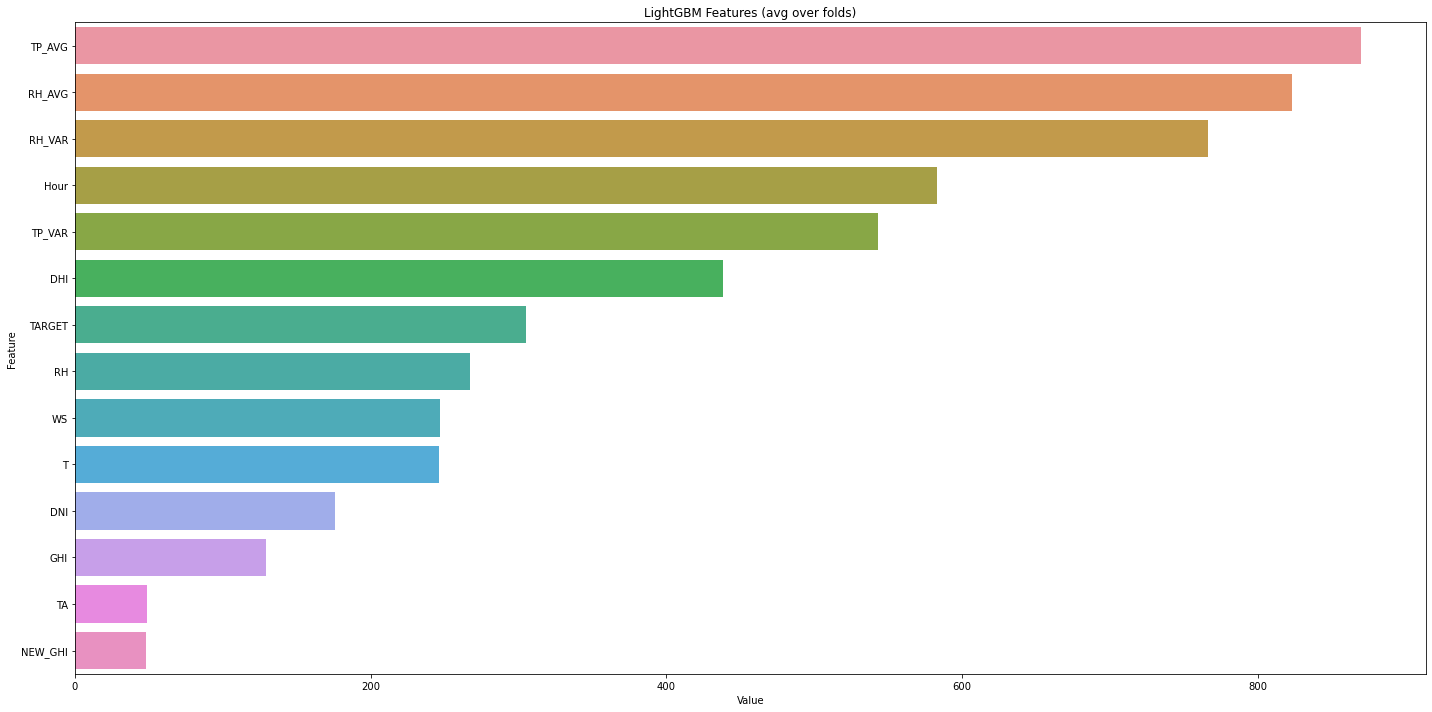

<Figure size 432x288 with 0 Axes>

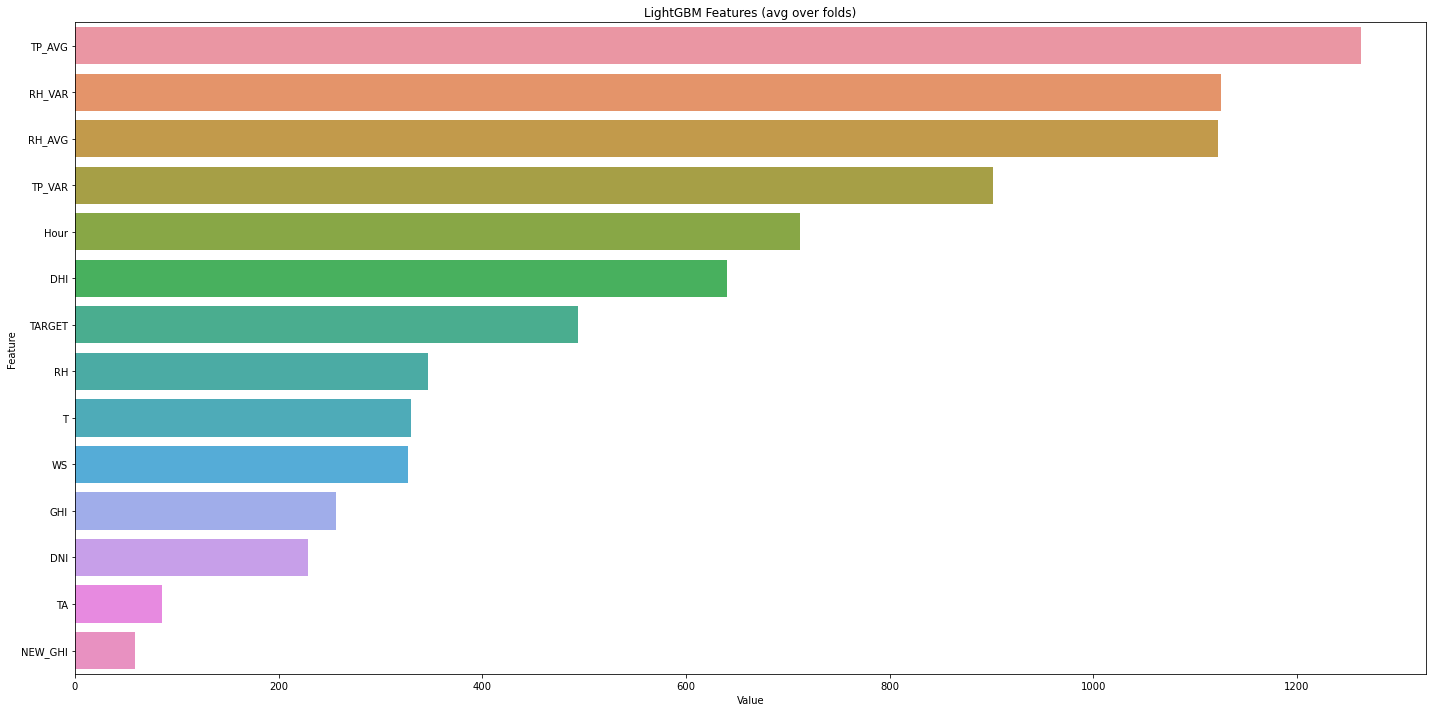

<Figure size 432x288 with 0 Axes>

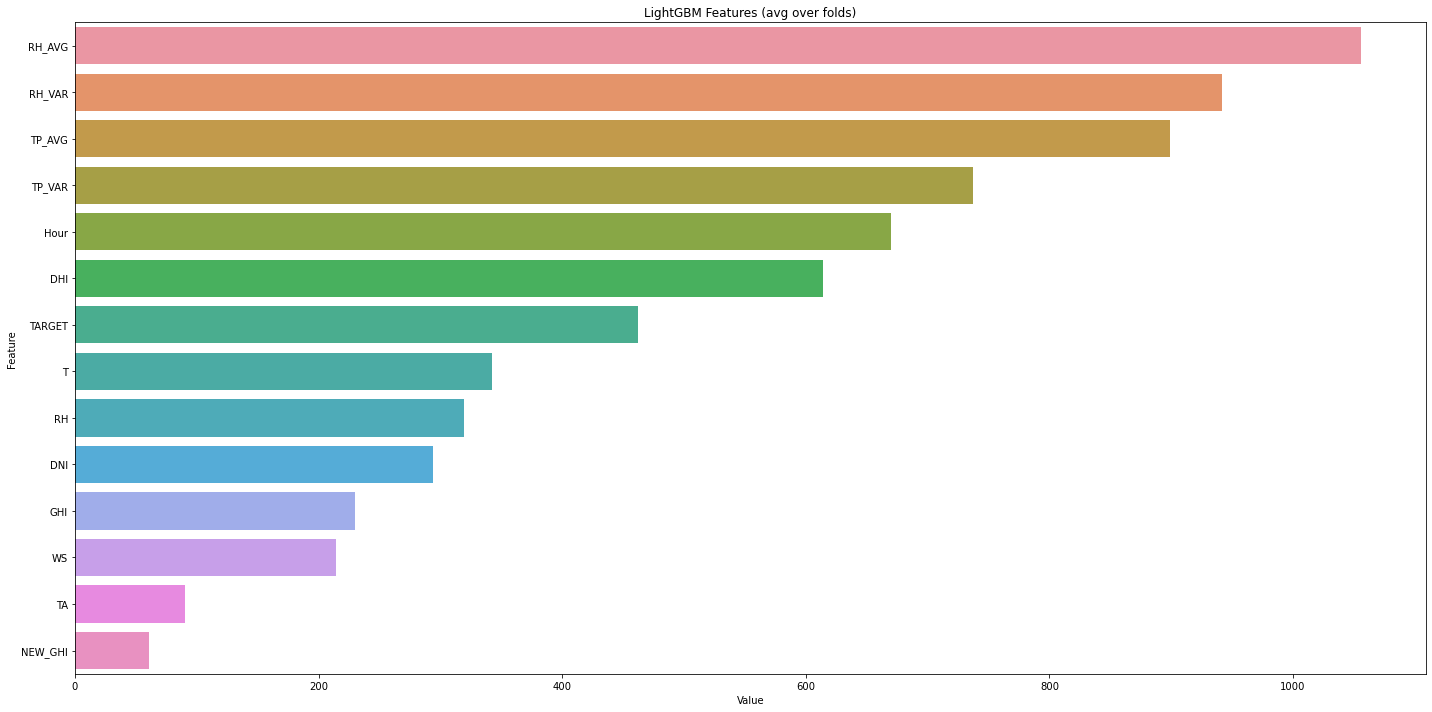

<Figure size 432x288 with 0 Axes>

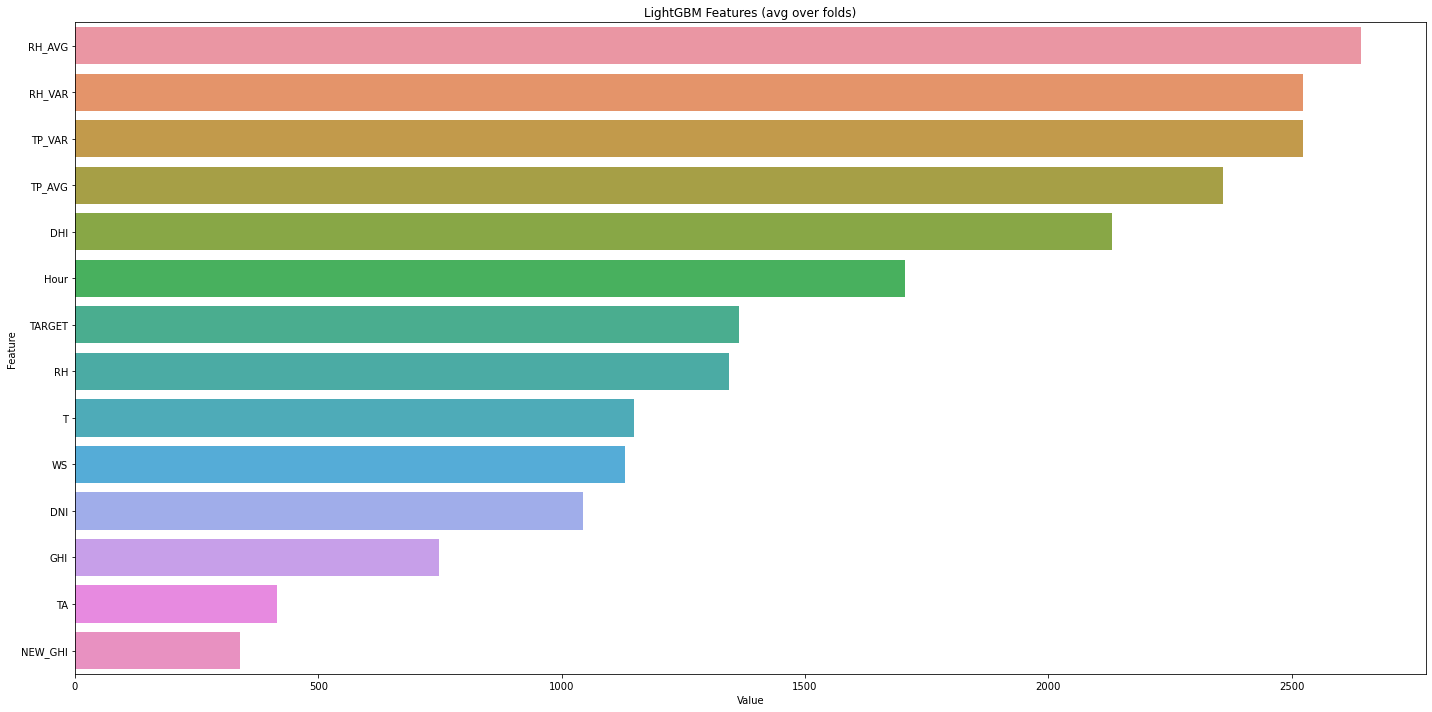

<Figure size 432x288 with 0 Axes>

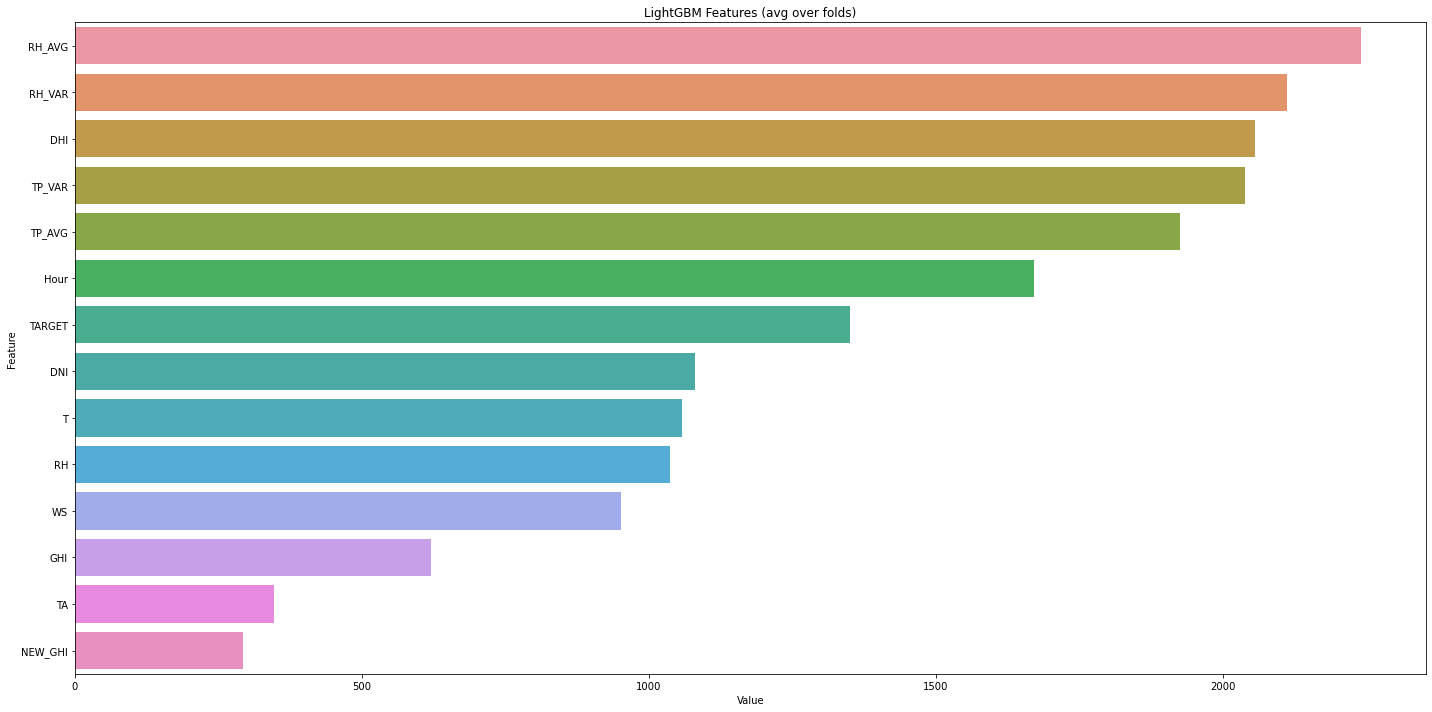

<Figure size 432x288 with 0 Axes>

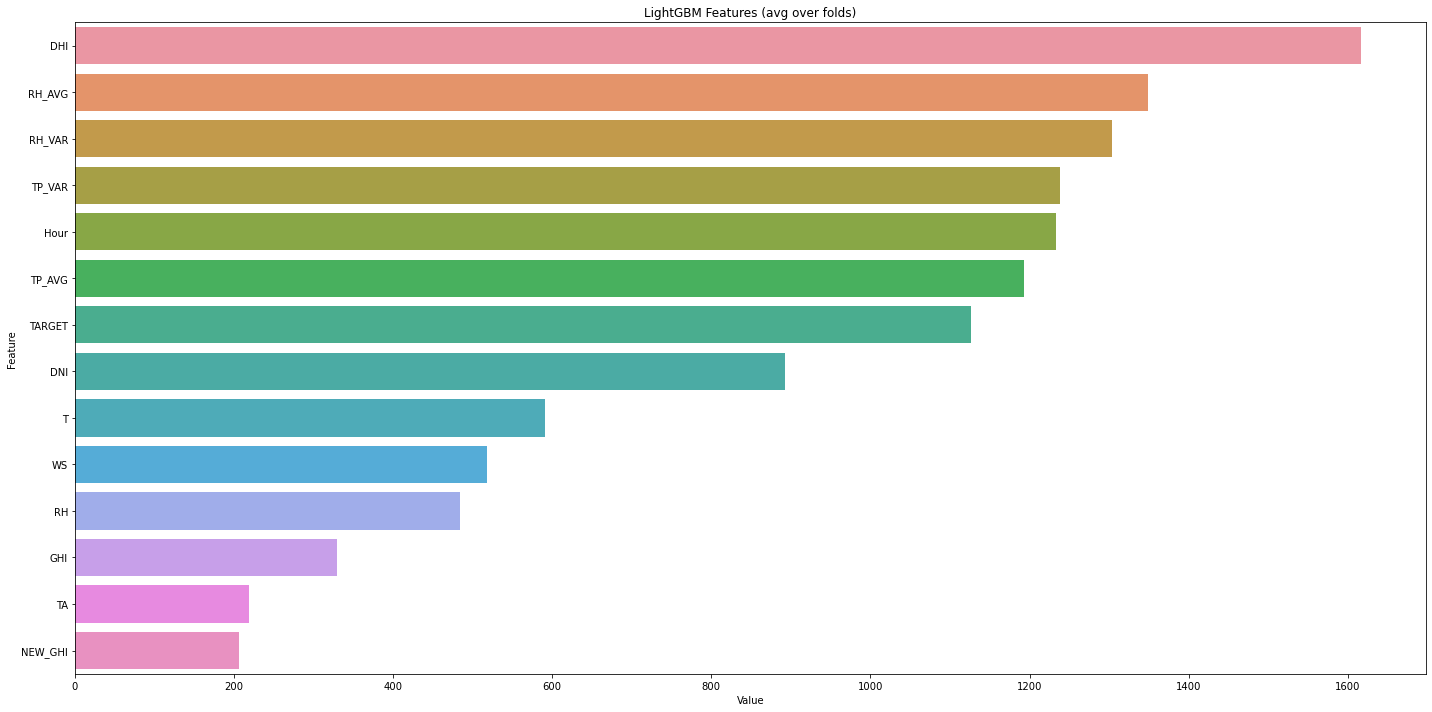

<Figure size 432x288 with 0 Axes>

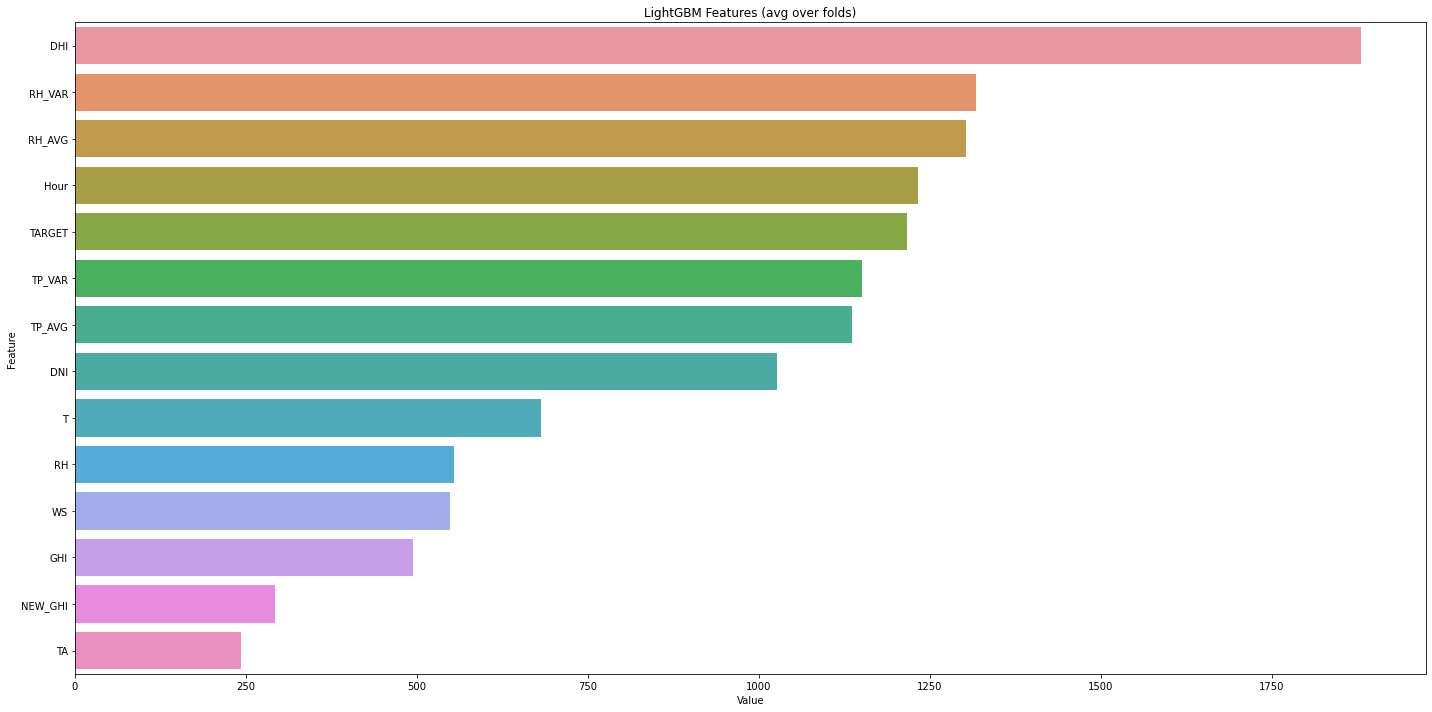

<Figure size 432x288 with 0 Axes>

In [30]:
for i in range(len(models_1)):
    # sorted(zip(clf.feature_importances_, X.columns), reverse=True)
    feature_imp = pd.DataFrame(sorted(zip(models_1[i].feature_importances_,x_train.columns)),
                               columns=['Value','Feature'])

    plt.figure(figsize=(20, 10))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()
    plt.savefig('lgbm_importances-01.png')

In [32]:
# lag model 3 window decross model

submission.loc[submission.id.str.contains("Day7"), "q_0.1":] = results_1.sort_index().values
submission.loc[submission.id.str.contains("Day8"), "q_0.1":] = results_2.sort_index().values
submission[14:33]

#submission.to_csv('./submission/submission_210102_4_2windowDecross.csv', index=False)

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
14,0.csv_Day7_7h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
15,0.csv_Day7_7h30m,0.62,0.90,1.80,2.10,2.00,0.75,2.63,1.91,6.32
16,0.csv_Day7_8h00m,1.41,3.47,6.76,7.14,7.09,6.00,7.80,10.51,18.85
17,0.csv_Day7_8h30m,2.77,5.68,7.36,11.13,11.33,14.16,16.93,16.21,24.13
18,0.csv_Day7_9h00m,4.23,6.99,9.48,13.72,15.21,8.63,7.33,15.65,28.99
19,0.csv_Day7_9h30m,4.60,6.02,7.08,18.34,22.10,16.35,15.25,19.92,32.82
20,0.csv_Day7_10h00m,7.54,8.85,11.82,18.62,20.61,21.32,26.01,22.56,26.94
21,0.csv_Day7_10h30m,7.94,10.07,13.57,20.72,24.09,26.06,31.46,29.36,32.68
22,0.csv_Day7_11h00m,7.54,8.83,12.65,20.02,23.17,27.65,31.01,32.66,32.81
23,0.csv_Day7_11h30m,7.54,9.31,12.94,20.45,21.85,27.68,26.06,24.71,31.91
